In [1]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.model_selection import KFold
from os.path import isfile
from datetime import datetime
%matplotlib inline

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import Session

config = ConfigProto()
config.gpu_options.allow_growth = True
sess = Session(config=config)

if tf.test.gpu_device_name():
    print("GPU found")
else:
    print("No GPU found")

GPU found


## Load training and Validation arrays

In [3]:
dict_genres = {'Blues':0, 'Classical':1, 'Country':2, 'Disco':3, 'Hip-Hop':4, 'Jazz':5, 'Metal':6, 'Pop':7, 'Reggae':8, 'Rock':9}

reverse_map = {v: k for k, v in dict_genres.items()}
print(reverse_map)

{0: 'Blues', 1: 'Classical', 2: 'Country', 3: 'Disco', 4: 'Hip-Hop', 5: 'Jazz', 6: 'Metal', 7: 'Pop', 8: 'Reggae', 9: 'Rock'}


In [4]:
npzfile = np.load('data/all_targets_sets_train.npz')
print(npzfile.files)

X_train = npzfile['arr_0']
y_train = npzfile['arr_1']
print(X_train.shape, y_train.shape)

['arr_0', 'arr_1']
(7992, 128, 128) (7992, 10)


In [5]:
npzfile = np.load('data/all_targets_sets_valid.npz')
print(npzfile.files)

X_valid = npzfile['arr_0']
y_valid = npzfile['arr_1']
print(X_valid.shape, y_valid.shape)

['arr_0', 'arr_1']
(999, 128, 128) (999, 10)


## Check by plotting a Spectogram

Country
(128, 128)


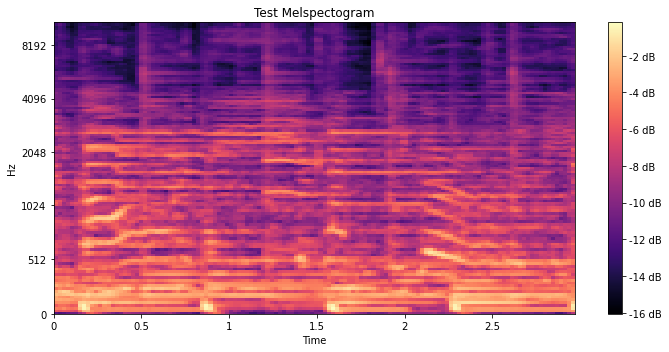

In [6]:
num = 0
spectogram = X_train[num]
genre = np.argmax(y_train[num])
print(reverse_map[genre])
print(spectogram.shape)
plt.figure(figsize=(10, 5))
librosa.display.specshow(spectogram.T, y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Test Melspectogram')
plt.tight_layout()

## Parallel CNN - RNN Model

In [7]:
batch_size = 32
num_classes = 2
n_features = X_train.shape[2]
n_time = X_train.shape[1]

In [8]:
nb_filters1=32
nb_filters2=64
nb_filters3=128
nb_filters4=512
ksize = (3,3)
pool_size_1= (2,2)

EPOCH_COUNT = 30

def conv_recurrent_model_build(model_input):
    print('Building model...')
    layer = model_input
    
    ### Convolutional blocks
    conv_1 = Conv2D(filters = nb_filters1, kernel_size = ksize, strides=1, padding= 'valid', activation='relu', name='conv_1')(layer)
    pool_1 = MaxPooling2D(pool_size_1)(conv_1)

    conv_2 = Conv2D(filters = nb_filters2, kernel_size = ksize, strides=1, padding= 'valid', activation='relu', name='conv_2')(pool_1)
    pool_2 = MaxPooling2D(pool_size_1)(conv_2)

    conv_3 = Conv2D(filters = nb_filters3, kernel_size = ksize, strides=1, padding= 'valid', activation='relu', name='conv_3')(pool_2)
    pool_3 = MaxPooling2D(pool_size_1)(conv_3)
    
    conv_4 = Conv2D(filters = nb_filters4, kernel_size = ksize, strides=1, padding= 'valid', activation='relu', name='conv_4')(pool_3)
    pool_4 = MaxPooling2D(pool_size_1)(conv_4)
    
    flatten1 = Flatten()(pool_4)
    
    output = Dense(num_classes, activation = 'softmax', name='preds')(flatten1)
    
    model_output = output
    model = Model(model_input, model_output)
    
    opt = Adam(learning_rate=0.001)
    
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    print(model.summary())
    return model

In [9]:
def train_model(x_train, y_train, x_val, y_val, info = "", genres_name = ""):
    n_frames = 128
    n_frequency = 128
    
    #reshape and expand dims for conv2d
    x_train = np.expand_dims(x_train, axis = -1)
    x_val = np.expand_dims(x_val, axis = -1)
       
    input_shape = (n_frames, n_frequency, 1)
    model_input = Input(input_shape, name='input')
    
    model = conv_recurrent_model_build(model_input)
    
    log_dir = "./logs/tree_7/model_root/"+datetime.now().strftime("%Y%m%d-%H%M%S_")+info
    tb_callback = TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True, write_images=False, update_freq='batch', profile_batch=2, embeddings_freq=0, embeddings_metadata=None)

    model_folder = "./models/tree_7/model_root/{}".format(info)
    os.makedirs(model_folder, exist_ok=True)
    
    f = open("{}/info.txt".format(model_folder), "w")
    f.write("genre name split: {}".format(genres_name))
    checkpoint_callback = ModelCheckpoint('{}/model.h5'.format(model_folder), monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    
    reducelr_callback = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=10, min_delta=0.01, verbose=1)
    callbacks_list = [tb_callback, checkpoint_callback, reducelr_callback]
    
    f.close()
    
    # Fit the model and get training history.
    print('Training...')
    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=EPOCH_COUNT, validation_data=(x_val, y_val), verbose=1, callbacks=callbacks_list)
    
    return model, history

In [10]:
def chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [11]:
def create_split(elem, c):
    splits = []
    for i in range(c):
        equal = False
        np.random.shuffle(elem)
        new_split = list(chunks(elem, int(len(elem)/2)))
        for split in splits:
            if set(new_split[0]) == set(split[0]) and set(new_split[0]) == set(split[1]):
                equal = True
                break
            
        if equal:
            i-=1
            continue
        
        splits.append(new_split)
        
    return splits

In [12]:
def show_summary_stats(history):
    # List all data in history
    print(history.history.keys())

    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

Folder num 1
Genre split [['Jazz', 'Disco', 'Metal', 'Rock', 'Country'], ['Classical', 'Blues', 'Reggae', 'Pop', 'Hip-Hop']]
Building model...
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 128)  

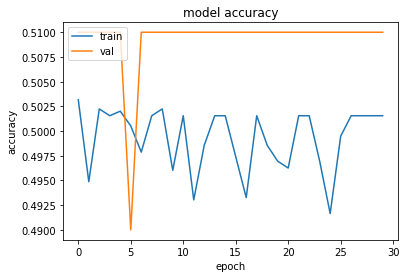

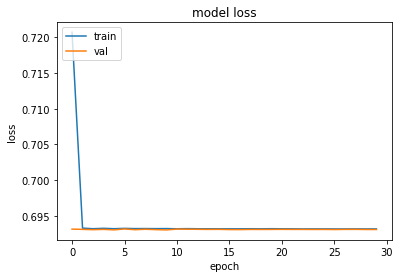

Folder num 2
Genre split [['Disco', 'Hip-Hop', 'Jazz', 'Metal', 'Blues'], ['Reggae', 'Classical', 'Pop', 'Country', 'Rock']]
Building model...
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 128)

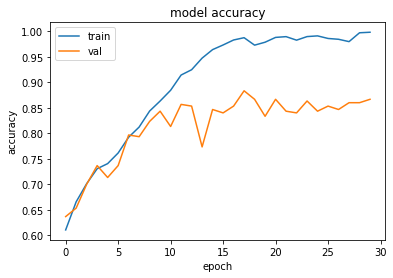

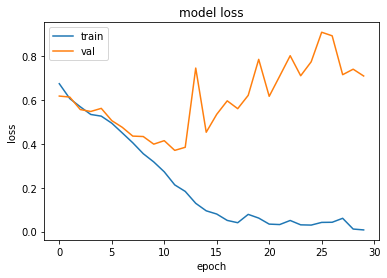

Folder num 3
Genre split [['Classical', 'Hip-Hop', 'Metal', 'Country', 'Reggae'], ['Blues', 'Rock', 'Pop', 'Disco', 'Jazz']]
Building model...
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 128)

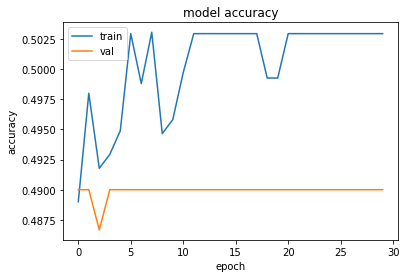

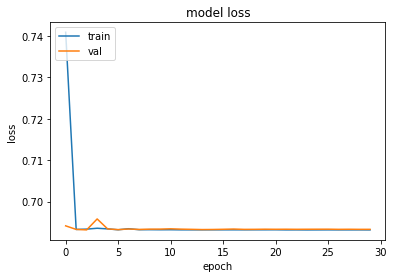

Folder num 4
Genre split [['Hip-Hop', 'Jazz', 'Pop', 'Classical', 'Reggae'], ['Rock', 'Blues', 'Metal', 'Disco', 'Country']]
Building model...
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 128)

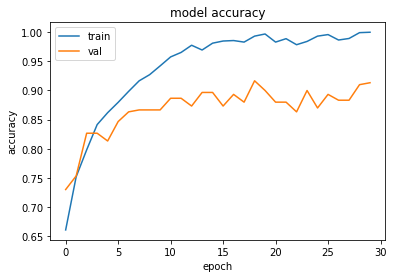

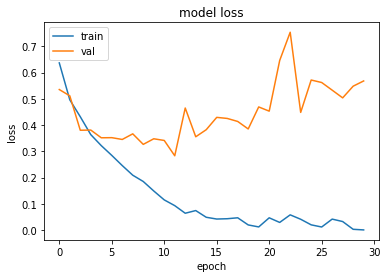

Folder num 5
Genre split [['Rock', 'Metal', 'Country', 'Disco', 'Jazz'], ['Hip-Hop', 'Reggae', 'Classical', 'Blues', 'Pop']]
Building model...
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 128)

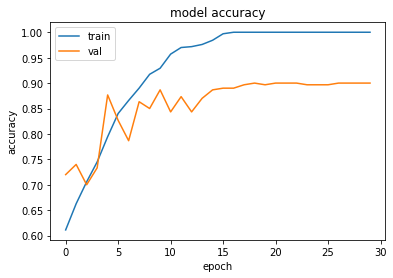

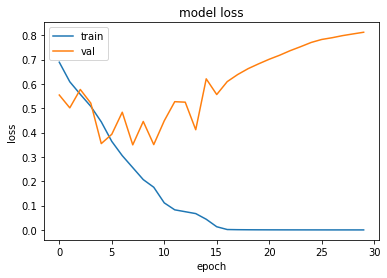

Folder num 6
Genre split [['Country', 'Jazz', 'Blues', 'Classical', 'Reggae'], ['Disco', 'Pop', 'Metal', 'Rock', 'Hip-Hop']]
Building model...
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 128)

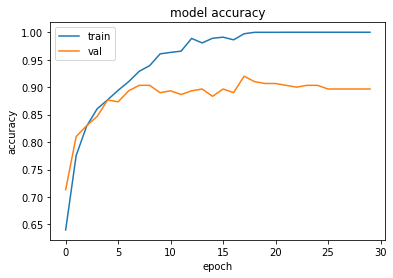

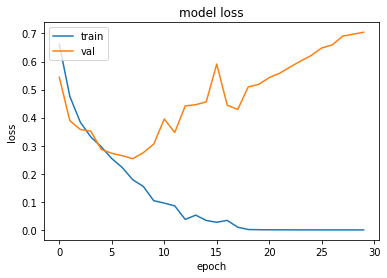

Folder num 7
Genre split [['Metal', 'Hip-Hop', 'Jazz', 'Blues', 'Country'], ['Reggae', 'Disco', 'Rock', 'Pop', 'Classical']]
Building model...
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 128)

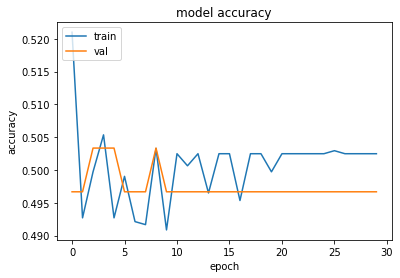

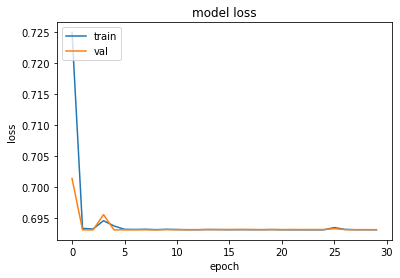

Folder num 8
Genre split [['Rock', 'Jazz', 'Classical', 'Disco', 'Metal'], ['Pop', 'Reggae', 'Country', 'Hip-Hop', 'Blues']]
Building model...
Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 128)

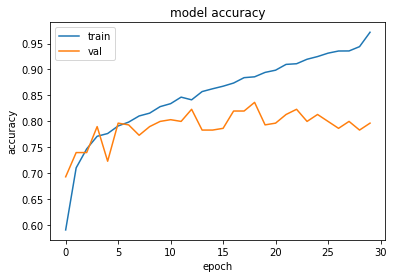

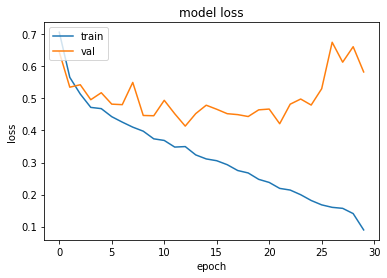

Folder num 9
Genre split [['Metal', 'Jazz', 'Rock', 'Disco', 'Reggae'], ['Blues', 'Classical', 'Country', 'Pop', 'Hip-Hop']]
Building model...
Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 128)

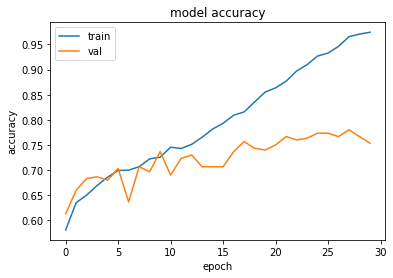

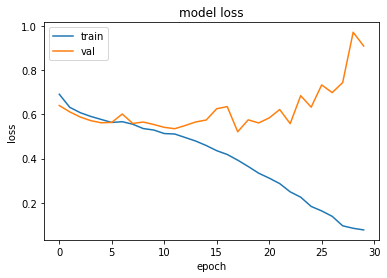

Folder num 10
Genre split [['Pop', 'Rock', 'Jazz', 'Hip-Hop', 'Reggae'], ['Blues', 'Classical', 'Country', 'Metal', 'Disco']]
Building model...
Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 128

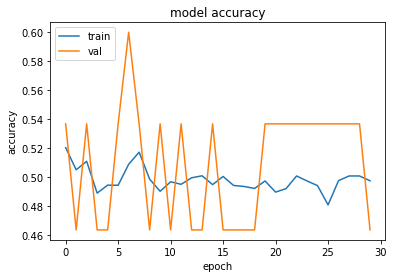

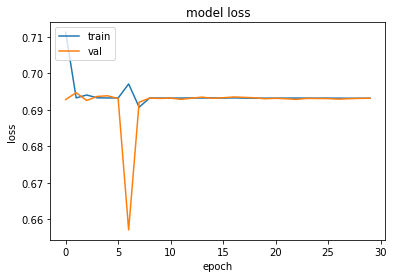

Folder num 11
Genre split [['Blues', 'Hip-Hop', 'Jazz', 'Metal', 'Country'], ['Pop', 'Disco', 'Classical', 'Reggae', 'Rock']]
Building model...
Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

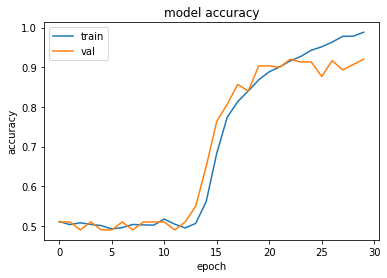

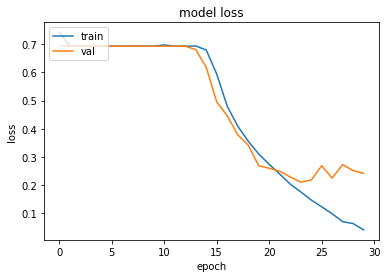

Folder num 12
Genre split [['Reggae', 'Jazz', 'Classical', 'Hip-Hop', 'Pop'], ['Country', 'Metal', 'Blues', 'Rock', 'Disco']]
Building model...
Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

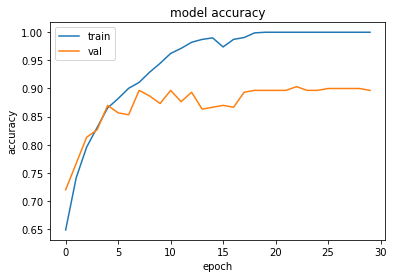

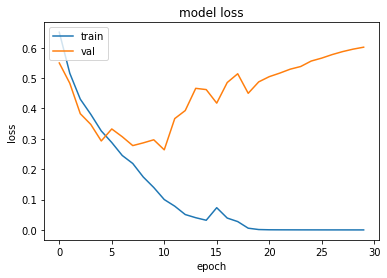

Folder num 13
Genre split [['Classical', 'Disco', 'Rock', 'Metal', 'Blues'], ['Reggae', 'Pop', 'Jazz', 'Country', 'Hip-Hop']]
Building model...
Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

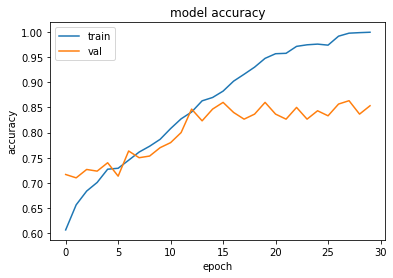

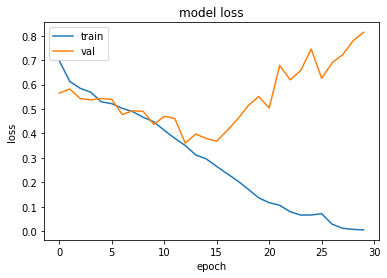

Folder num 14
Genre split [['Disco', 'Classical', 'Hip-Hop', 'Jazz', 'Reggae'], ['Rock', 'Pop', 'Metal', 'Blues', 'Country']]
Building model...
Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_53 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

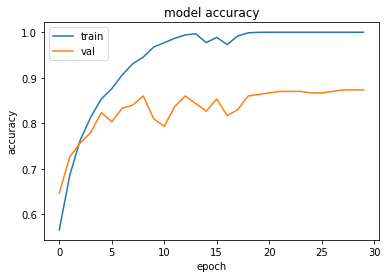

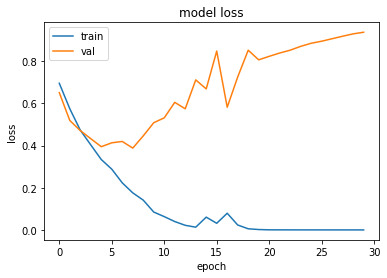

Folder num 15
Genre split [['Rock', 'Classical', 'Disco', 'Jazz', 'Pop'], ['Country', 'Hip-Hop', 'Blues', 'Reggae', 'Metal']]
Building model...
Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

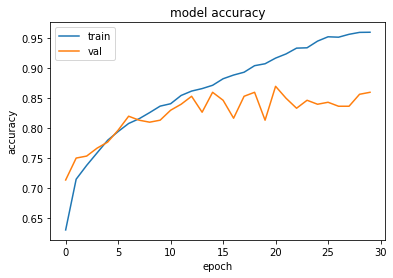

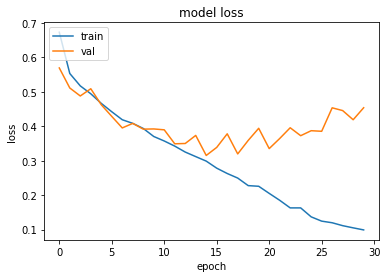

Folder num 16
Genre split [['Blues', 'Jazz', 'Rock', 'Reggae', 'Disco'], ['Classical', 'Country', 'Pop', 'Hip-Hop', 'Metal']]
Building model...
Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_60 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_61 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

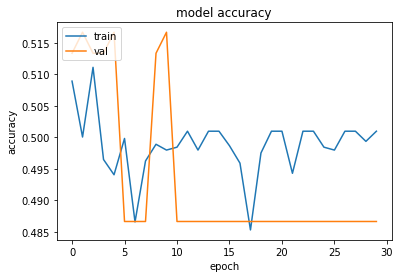

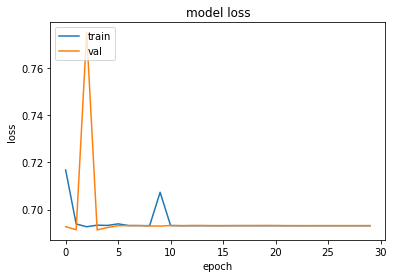

Folder num 17
Genre split [['Classical', 'Jazz', 'Disco', 'Hip-Hop', 'Blues'], ['Metal', 'Country', 'Rock', 'Reggae', 'Pop']]
Building model...
Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_64 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_65 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

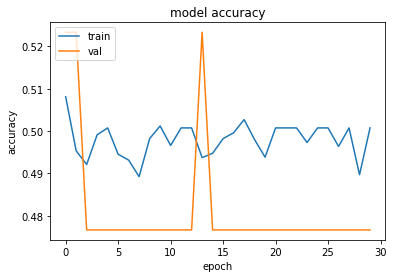

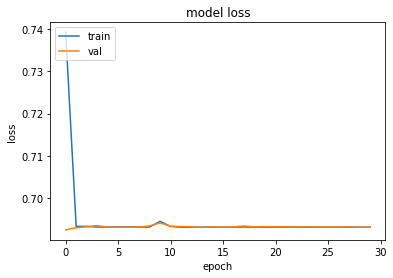

Folder num 18
Genre split [['Blues', 'Reggae', 'Country', 'Pop', 'Rock'], ['Jazz', 'Metal', 'Hip-Hop', 'Classical', 'Disco']]
Building model...
Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_68 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_69 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

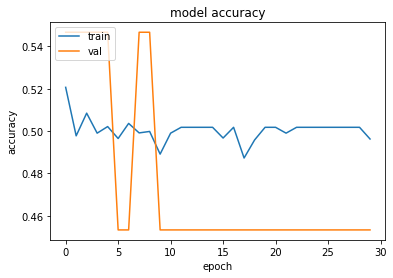

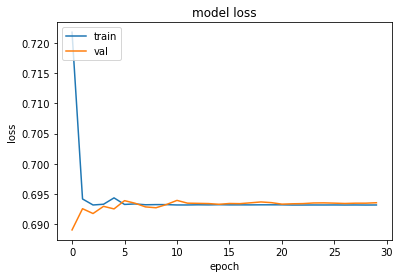

Folder num 19
Genre split [['Classical', 'Reggae', 'Rock', 'Blues', 'Jazz'], ['Metal', 'Country', 'Disco', 'Hip-Hop', 'Pop']]
Building model...
Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_72 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_73 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

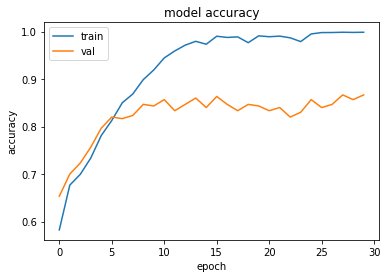

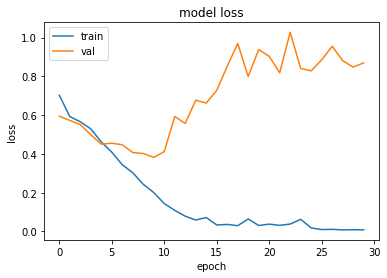

Folder num 20
Genre split [['Jazz', 'Metal', 'Blues', 'Pop', 'Disco'], ['Reggae', 'Classical', 'Rock', 'Hip-Hop', 'Country']]
Building model...
Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_76 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_77 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

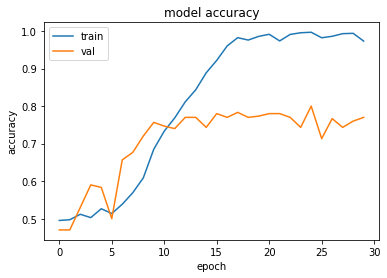

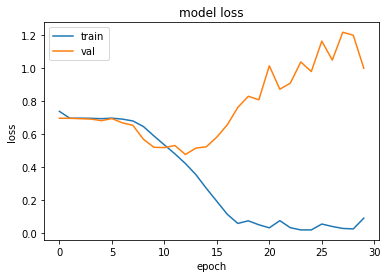

Folder num 21
Genre split [['Reggae', 'Blues', 'Jazz', 'Hip-Hop', 'Rock'], ['Country', 'Pop', 'Metal', 'Disco', 'Classical']]
Building model...
Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_80 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_81 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

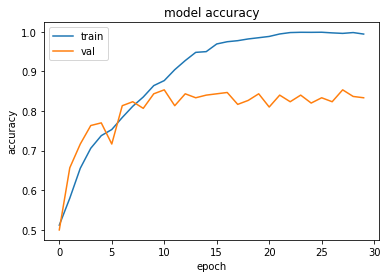

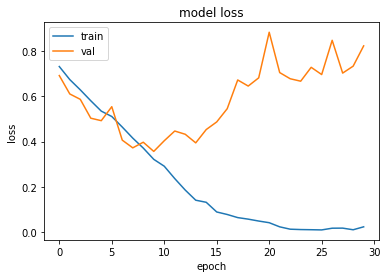

Folder num 22
Genre split [['Jazz', 'Disco', 'Classical', 'Reggae', 'Rock'], ['Pop', 'Hip-Hop', 'Blues', 'Metal', 'Country']]
Building model...
Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_84 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_85 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

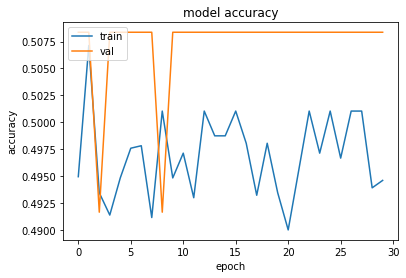

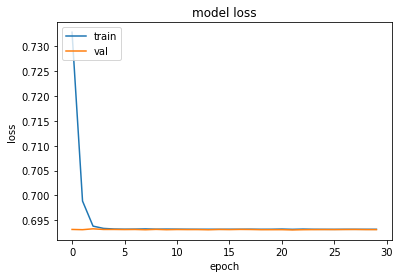

Folder num 23
Genre split [['Metal', 'Reggae', 'Pop', 'Jazz', 'Rock'], ['Country', 'Classical', 'Disco', 'Blues', 'Hip-Hop']]
Building model...
Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_88 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_89 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

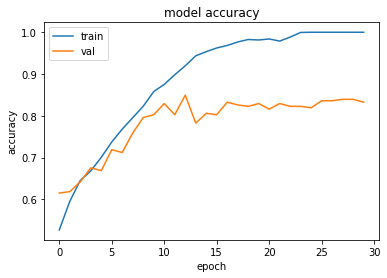

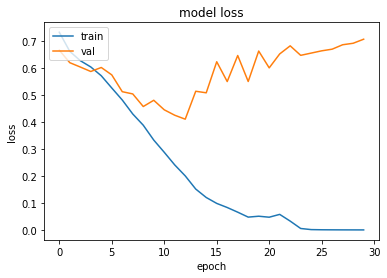

Folder num 24
Genre split [['Jazz', 'Reggae', 'Classical', 'Blues', 'Country'], ['Hip-Hop', 'Pop', 'Disco', 'Metal', 'Rock']]
Building model...
Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_92 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_93 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

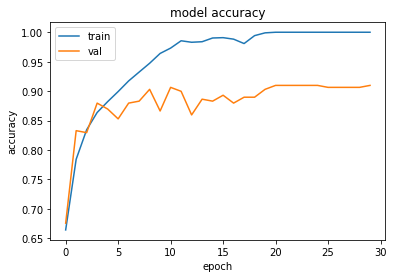

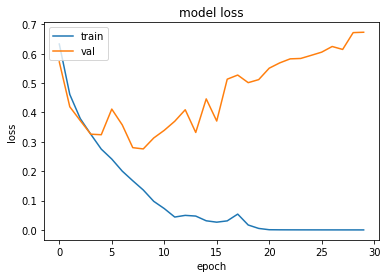

Folder num 25
Genre split [['Blues', 'Rock', 'Pop', 'Country', 'Metal'], ['Jazz', 'Disco', 'Classical', 'Hip-Hop', 'Reggae']]
Building model...
Model: "model_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_96 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_97 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

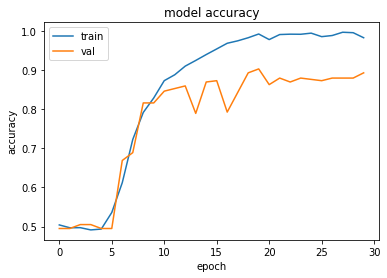

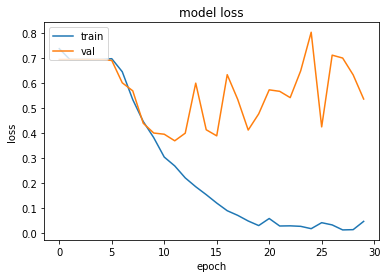

Folder num 26
Genre split [['Country', 'Rock', 'Metal', 'Blues', 'Classical'], ['Reggae', 'Jazz', 'Hip-Hop', 'Disco', 'Pop']]
Building model...
Model: "model_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_100 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_101 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

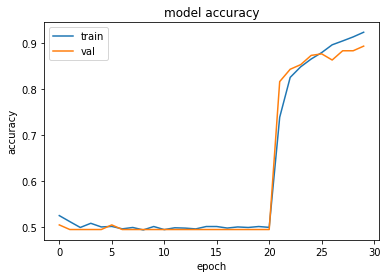

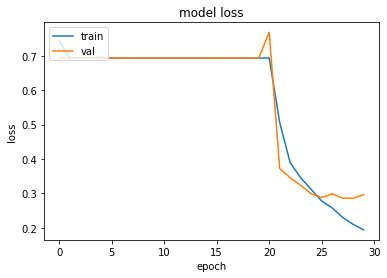

Folder num 27
Genre split [['Reggae', 'Hip-Hop', 'Pop', 'Jazz', 'Blues'], ['Classical', 'Disco', 'Metal', 'Country', 'Rock']]
Building model...
Model: "model_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_104 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_105 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

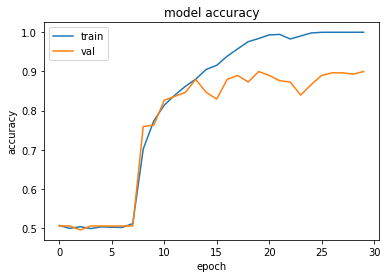

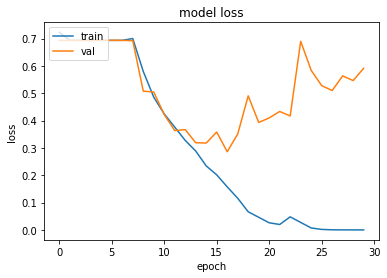

Folder num 28
Genre split [['Reggae', 'Pop', 'Classical', 'Rock', 'Metal'], ['Blues', 'Hip-Hop', 'Disco', 'Jazz', 'Country']]
Building model...
Model: "model_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_108 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_109 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

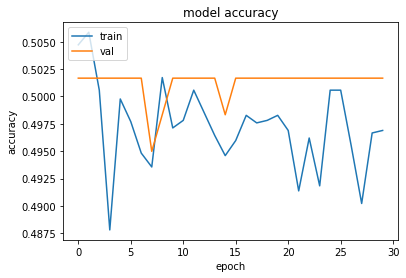

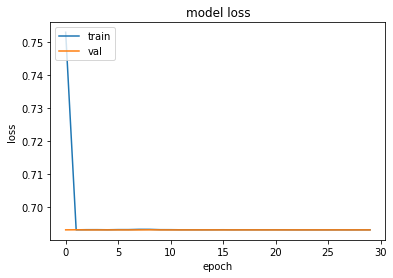

Folder num 29
Genre split [['Classical', 'Reggae', 'Pop', 'Jazz', 'Metal'], ['Blues', 'Rock', 'Hip-Hop', 'Disco', 'Country']]
Building model...
Model: "model_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_112 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_113 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

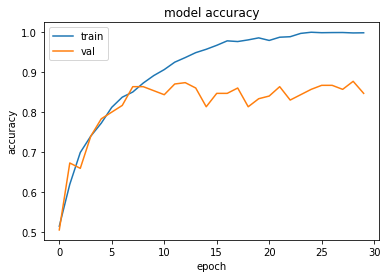

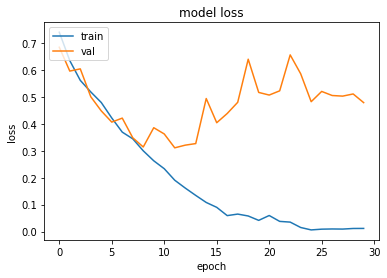

Folder num 30
Genre split [['Pop', 'Disco', 'Country', 'Rock', 'Metal'], ['Reggae', 'Jazz', 'Blues', 'Classical', 'Hip-Hop']]
Building model...
Model: "model_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_116 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_117 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

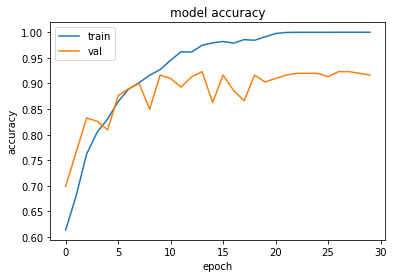

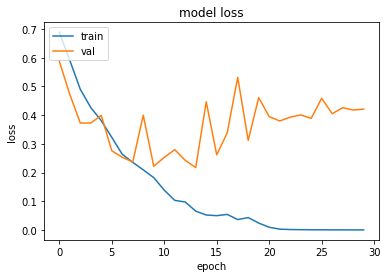

In [13]:
X_train_cross = np.concatenate((X_train, X_valid), axis=0)
y_train_cross = np.concatenate((y_train, y_valid), axis=0)

num_splits = 30

kfold = KFold(n_splits=30, shuffle=True)
genre_splits = create_split(list(dict_genres.values()), num_splits)

fold_no = 1
for train, test in kfold.split(X_train_cross, y_train_cross):
    split = genre_splits[fold_no - 1]
    
    y_train_cross_binary = np.argmax(y_train_cross, axis=1)
    y_train_cross_binary = np.in1d(y_train_cross_binary, split[0])
    y_train_cross_binary = utils.to_categorical(y_train_cross_binary*1, num_classes=2)
    
    print("Folder num {}".format(fold_no))
    genres_name = [[reverse_map[g] for g in split_l] for split_l in split]
    print("Genre split {}".format(genres_name))
    
    model, history  = train_model(X_train_cross[train], y_train_cross_binary[train], X_train_cross[test], y_train_cross_binary[test], "folder{}".format(fold_no), genres_name)
    show_summary_stats(history)
    
    fold_no += 1
    if fold_no > num_splits:
        break